<u><center><h1>Udacity MLND Capstone Project</h1>
<h2>Plant Seedling Classfication</h2></center></u> 
<p> This project is taken from the <a href='https://www.kaggle.com/c/plant-seedlings-classification'>kaggle competition</a>. It aims at detecting plant as a part of one of the 12 categories and will help in effective weed management.</p>
<p> The code below is broken down in the following sections:
    <ul>
        <li> Data Exploration</li>
        <li> Pre-processing of data </li>
        <li> Creating CNN Model </li>
        <li> Comparing Results </li>

## 1. DATA EXPLORATION

### Loading the data set

In [ ]:
# import required components
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
import numpy as np
import os

In [2]:
''' 
Here we are going to load our training and test dataset 
and see the count of files in both of them as well as the defined categories of lant ssedling data set.
'''
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return plant_files, plant_targets

# load train and testdatasets
train_files, train_targets = load_dataset('seedlingdata/train')

# load list of plant seedling categories
categories = [item[19:-1] for item in sorted(glob("seedlingdata/train/*/"))]

# find count of files under test data
test_path, test_dirs, test_files = next(os.walk("seedlingdata/test"))
test_file_count = len(test_files)

# print statistics about the dataset
print('---------------')
print('TRAINING DATA')
print('---------------')
print('There are %d training plant seedling images.' % len(train_files))
print('There are %d total plant seedling categories' % len(categories))
print('List of categories:',categories)

print('---------------')
print('TEST DATA')
print('---------------')
print('There are %d test plant seedling images.' % test_file_count)

---------------
TRAINING DATA
---------------
There are 4750 training plant seedling images.
There are 12 total plant seedling categories
List of categories: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
---------------
TEST DATA
---------------
There are 794 test plant seedling images.


### Data Distribution

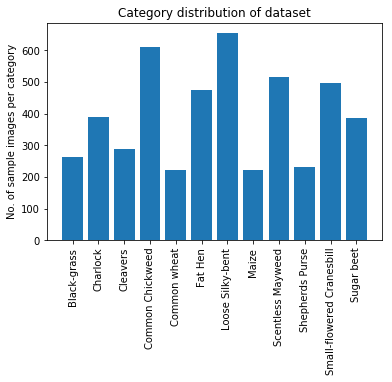

-----------------
DATA DISTRIBUTION
-----------------
1. Black-grass has 263 records
2. Charlock has 390 records
3. Cleavers has 287 records
4. Common Chickweed has 611 records
5. Common wheat has 221 records
6. Fat Hen has 475 records
7. Loose Silky-bent has 654 records
8. Maize has 221 records
9. Scentless Mayweed has 516 records
10. Shepherds Purse has 231 records
11. Small-flowered Cranesbill has 496 records
12. Sugar beet has 385 records


In [23]:
import matplotlib.pyplot as plt

category_count = np.sum(train_targets, axis=0)
'''
Function for displaying categorical data distribution to check if dataset is balanced
TODO: data augmentation if dataset is unbalanced
'''
def categorical_dist_graph(categories, count):
    fig, ax = plt.subplots()
   # ax.step(np.arange(len(categories)), count)
    ax.bar(np.arange(len(categories)), count)
    ax.set_ylabel('No. of sample images per category')
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation = 'vertical')
    ax.set_title('Category distribution of dataset')
    plt.show()

categorical_dist_graph(categories, category_count)

print("-----------------")
print("DATA DISTRIBUTION")
print("-----------------")
for i in range(0,12):
    print('%d. %s has %d records' % (i+1, categories[i], category_count[i]))
    


### Sample Images from each category

In [32]:
import cv2
%matplotlib inline

for root, dirs, files in os.walk("seedlingdata/train"):  
    for directory in dirs:
        print(directory)
        count = 0
        for root, dirs, files in os.walk("seedlingdata/train/"+directory):
            for file in files:
                img = cv2.imread(img_path)
                cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                imgplot = plt.imshow(cv_rgb)

                


Cleavers


NameError: name 'img_path' is not defined

In [ ]:
import cv2
%matplotlib inline

# create a dictionary of all the files and categories
def create_category_dict(file_names, categories):
    # loop over all file names
    for category in categories:
        for file in file_names:
            if 

def display_img(img_path):
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

